# TSQR vs Randomized SVD algorithms

This notebook compares the Tall-and-Skinny QR factorization (TSQR) algorithm vs the Randomized algorithm for computing the SVD of a tall-and-skinny matrix (i.e. many more rows than columns). Both of these algorithms are supported by the `TruncatedSVD` class in SVDROM.

The TSQR algorithm provides accurate results when computing the SVD, while the randomized algorithm provides an approximation. However, as we will see the randomized algorithm is much faster and scalable, and if we give it the right parameters, we can also achieve high accuracy.

In [1]:
import matplotlib.pyplot as plt
import numpy as np

from svdrom.dask_utils import init_dask
from svdrom.io import open_dataarray
from svdrom.preprocessing import StandardScaler, variable_spatial_stack
from svdrom.svd import TruncatedSVD

Start a local multi-thread cluster. This is appropriate for the current task because the large dataset stored on disk means the workload is I/O-bound. Additionally, Dask's SVD algorithms use numerical libraries that release Python's Global Interpreter Lock (GIL), meaning that multithreading can still allow parallelism even within a single process.

You can monitor computation progress on the Dask Dashboard (http://localhost:8787/status).

In [2]:
client = init_dask(dashboard=True)

2025-07-30 17:59 - Dask Setup - INFO - Started a local multi-thread Dask cluster with dashboard support.
2025-07-30 17:59 - Dask Setup - INFO - Dashboard link: http://localhost:8787/status


2025-07-30 18:01:28,128 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 62925267306450e882b6981f384697fd initialized by task ('reshape-sub-transpose-rechunk-transfer-922a666552218db5c4403c848ae5c6ad', 0, 0, 0, 67) executed on worker inproc://192.168.1.116/67420/4
2025-07-30 18:01:40,211 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 62925267306450e882b6981f384697fd deactivated due to stimulus 'task-finished-1753894900.210697'


Open the [ERA5](https://weatherbench2.readthedocs.io/en/latest/data-guide.html#era5) slice, saved on disk as a Zarr file, as a Xarray DataArray. The data is not loaded into memory by this operation.

In [3]:
era5_path = "data/era5_slice.zarr"
X = open_dataarray(era5_path)

2025-07-30 17:59 - I/O - INFO - Opening Xarray.DataArray from data/era5_slice.zarr.


The array contains a single variable, atmospheric temperature, on a 0.25 deg lat/lon grid, at a single pressure level (500 hPa), sampled across 2018 with a frequency of 2h.

In [4]:
X

<xarray.DataArray 'temperature' (time: 4380, latitude: 721, longitude: 1440)> Size: 18GB
dask.array<open_dataset-temperature, shape=(4380, 721, 1440), dtype=float32, chunksize=(32, 721, 1440), chunktype=numpy.ndarray>
Coordinates:
  * longitude  (longitude) float32 6kB 0.0 0.25 0.5 0.75 ... 359.2 359.5 359.8
  * time       (time) datetime64[ns] 35kB 2018-01-01 ... 2018-12-31T22:00:00
    level      int64 8B ...
  * latitude   (latitude) float32 3kB 90.0 89.75 89.5 ... -89.5 -89.75 -90.0
Attributes:
    long_name:      Temperature
    short_name:     t
    standard_name:  air_temperature
    units:          K

I have struggled to compute a SVD locally on my laptop with the TSQR algorithm on arrays larger than 10 GB. The randomized algorithm, on the other hand, is much more memory efficient. To compare the results provided by both algorithms, here we will operate on a smaller slice corresponding to the first half of the year, which yields an array of approximately 8.40 GiB. 

In [5]:
X = X.sel(time=slice("2018-01-01", "2018-06-30"))

In [6]:
X

<xarray.DataArray 'temperature' (time: 2172, latitude: 721, longitude: 1440)> Size: 9GB
dask.array<getitem, shape=(2172, 721, 1440), dtype=float32, chunksize=(32, 721, 1440), chunktype=numpy.ndarray>
Coordinates:
  * longitude  (longitude) float32 6kB 0.0 0.25 0.5 0.75 ... 359.2 359.5 359.8
  * time       (time) datetime64[ns] 17kB 2018-01-01 ... 2018-06-30T22:00:00
    level      int64 8B ...
  * latitude   (latitude) float32 3kB 90.0 89.75 89.5 ... -89.5 -89.75 -90.0
Attributes:
    long_name:      Temperature
    short_name:     t
    standard_name:  air_temperature
    units:          K

Use the StandardScaler class to compute the mean along the time dimension and to subtract it from the array. You can check the Dask dashboard to monitor how Dask handles this operation.

In [7]:
scaler = StandardScaler()
X = scaler(X)

2025-07-30 18:00 - Preprocessing - INFO - Computing mean along dimension time...
2025-07-30 18:01 - Preprocessing - INFO - Finished computing mean.


We now need to stack the latitude and longitude dimensions along a single spatial dimension, to obtain an array with shape `(samples, time)`. Here `samples` refers to the spatial dimension, whereas the different snapshots along the `time` dimension would play the role of different features. The stacking operation can be easily done with the `variable_spatial_stack` function.

In [8]:
X = variable_spatial_stack(X, dims=("latitude", "longitude"))

2025-07-30 18:01 - Preprocessing - INFO - Performing spatial stacking.


In [9]:
X

<xarray.DataArray 'temperature' (time: 2172, samples: 1038240)> Size: 9GB
dask.array<reshape, shape=(2172, 1038240), dtype=float32, chunksize=(32, 1038240), chunktype=numpy.ndarray>
Coordinates:
  * time       (time) datetime64[ns] 17kB 2018-01-01 ... 2018-06-30T22:00:00
    level      int64 8B 500
  * samples    (samples) object 8MB MultiIndex
  * latitude   (samples) float32 4MB 90.0 90.0 90.0 90.0 ... -90.0 -90.0 -90.0
  * longitude  (samples) float32 4MB 0.0 0.25 0.5 0.75 ... 359.2 359.5 359.8

Finally, we just need to transpose the array to obtain the shape `(samples, time)`, and then rechunk it. Explicit rechunking is not compulsory, as it is internally handled by the `TruncatedSVD` class when required, but doing it manually now allows for a fairer comparison of the performance of the TSQR and Randomized algorithms. Since our array is a tall-and-skinny matrix, we want to ensure there is a single column of chunks, i.e. chunking only takes place along the `samples` dimension.

In [10]:
X = X.T

# "auto" lets Dask choose an optimal chunk size,
# while -1 means don't chunk along this dimension.
X = X.chunk({"samples": "auto", "time": -1})

In [11]:
X

<xarray.DataArray 'temperature' (samples: 1038240, time: 2172)> Size: 9GB
dask.array<rechunk-p2p, shape=(1038240, 2172), dtype=float32, chunksize=(15448, 2172), chunktype=numpy.ndarray>
Coordinates:
  * time       (time) datetime64[ns] 17kB 2018-01-01 ... 2018-06-30T22:00:00
    level      int64 8B 500
  * samples    (samples) object 8MB MultiIndex
  * latitude   (samples) float32 4MB 90.0 90.0 90.0 90.0 ... -90.0 -90.0 -90.0
  * longitude  (samples) float32 4MB 0.0 0.25 0.5 0.75 ... 359.2 359.5 359.8

Up to this point all work is lazy, we have just told Dask to build a task graph to be computed later. We now want to trigger the task graph we have built so far, using `persist()`. The result of this operation will be kept on distributed RAM. Again, it is not necessary to do this manually, but by computing all the above pre-processing steps now, we can have a fairer comparison of the performance of the TSQR and Randomized algorithms. Note that the `persist()` operation is non-blocking, you get back control immediately as the computations occur in the background. You can monitor the computations on the Dask dashboard.

In [ ]:
X = X.persist()  # computed in the background, result stays on distributed RAM

We will now perform the SVD, first with the TSQR algorithm and then with the Randomized algorithm. In both cases we will truncate to 20 components.

In [13]:
n_components = 30

In [14]:
tsvd_tsqr = TruncatedSVD(
    n_components=n_components,
    algorithm="tsqr",
)

In [15]:
tsvd_tsqr.fit(X)

2025-07-30 18:01 - SVD - INFO - Will use TSQR algorithm.
2025-07-30 18:01 - SVD - INFO - Computing SVD results...
2025-07-30 18:05 - SVD - INFO - Done.


In [16]:
tsvd_randomized = TruncatedSVD(
    n_components=n_components,
    algorithm="randomized",
)

We will pass some additional argument to the `fit` method in the randomized SVD case. Namely, we will request 2 power iterations and 15 oversamples for generating the sampling matrix. Power iterations help improve accuracy when the singular values don't decay rapidly, while oversampling increases the size of the column subspace that is computed, also helping to improve accuracy at the expense of somewhat higher computational cost.

In [17]:
tsvd_randomized.fit(
    X,
    n_power_iter=2,
    n_oversamples=15,
)

2025-07-30 18:06 - SVD - INFO - Will use randomized algorithm.
2025-07-30 18:06 - SVD - INFO - Computing SVD results...
2025-07-30 18:06 - SVD - INFO - Done.


As can be seen from the above experiments, the TSQR algorithm took well over 3 minutes to perform the SVD, while the randomized algorithm took less than 10 seconds. To test the accuracy of the randomized SVD results relative to the TSQR results, we will compute the dot product of the singular vectors between one method and the other. Since the $\mathbf{U}$ and $\mathbf{V}$ matrices are unitary, by multiplying the singular vectors from both methods, we should obtain a matrix close to the identity matrix. The closer the result is to the identity matrix, the more similar the two sets of singular vectors are.

In [18]:
# note we are taking the absolute value here because the vectors could
# be parallel but pointing in opposite direction, i.e. their dot product
# could be -1 instead of 1. In practice, it doesn't matter if the sign is
# positive or negative, as long as the direction is the same.

dot_product = np.abs(tsvd_tsqr.v.data @ tsvd_randomized.v.data.T)

The dot product of both the left and right singular vectors is close to the identity matrix, which indicates that the two sets of singular vectors from the two different algorithms are very similar. Accuracy starts to reduce for singular vectors associated with smaller singular values, where the colormap becomes a bit blurry off the diagonal. This means that the randomized SVD algorithm provides results that are very close to those obtained with the TSQR algorithm, despite being much faster.

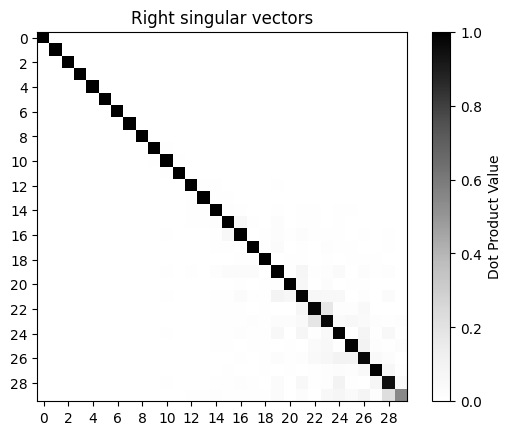

In [20]:
plt.imshow(dot_product, cmap="Grays", vmin=0, vmax=1)
plt.colorbar(label='Dot Product Value')
plt.title("Right singular vectors")
plt.xticks(range(0, n_components, 2))
plt.yticks(range(0, n_components, 2))
plt.show()

In [21]:
dot_product = np.abs(tsvd_tsqr.u.data.T @ tsvd_randomized.u.data)

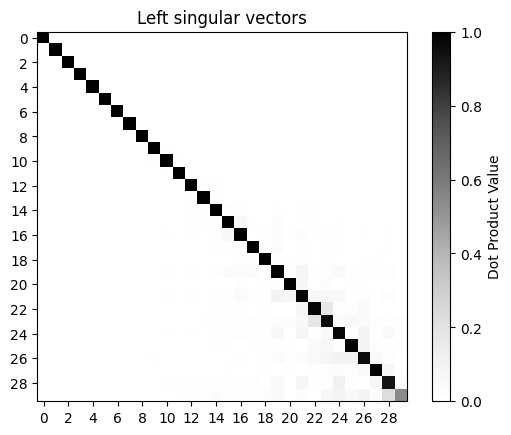

In [23]:
plt.imshow(dot_product, cmap="Grays", vmin=0, vmax=1)
plt.colorbar(label='Dot Product Value')
plt.xticks(range(0, n_components, 2))
plt.yticks(range(0, n_components, 2))
plt.title("Left singular vectors")
plt.show()

As can be seen, the singular values from both methods are almost identical, with accuracy starting to decrease somewhat for smaller singular values, approximately at the 15th component.

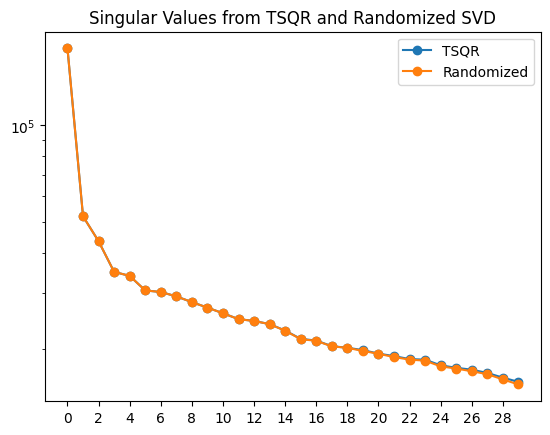

In [24]:
plt.plot(tsvd_tsqr.s, "-o", label="TSQR")
plt.plot(tsvd_randomized.s, "-o", label="Randomized")
plt.yscale("log")
plt.legend()
plt.title("Singular Values from TSQR and Randomized SVD")
plt.xticks(range(0, n_components, 2))
plt.show()

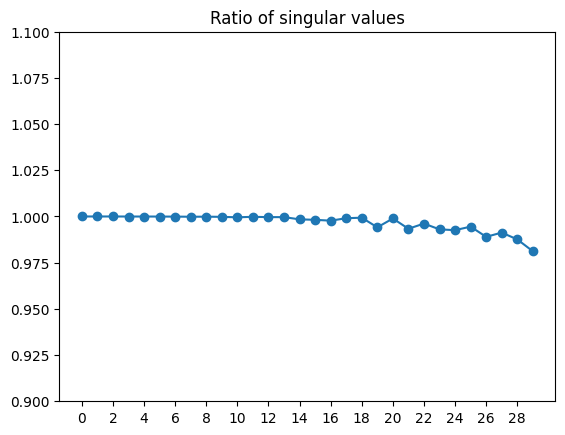

In [30]:
ratio = tsvd_randomized.s/tsvd_tsqr.s
plt.plot(ratio, "o-")
plt.title("Ratio of singular values")
plt.ylim([0.9, 1.1])
plt.xticks(range(0, n_components, 2))
plt.show()

Finally, let's compute the variance explained by each component using the `compute_var_ratio()` method. This is also done in parallel using Dask.

In [26]:
tsvd_randomized.compute_var_ratio()

2025-07-30 18:10 - SVD - INFO - Computing explained variance ratio...
2025-07-30 18:10 - SVD - INFO - Done.


As shown below, 30 components explain approximately 83% of the total variance, with the first component alone explaining about 50%. This highlights that the ERA5 dataset we are dealing with is clearly low-rank: despite the large dimensionality, there is a small number of components that explain most of the variance.

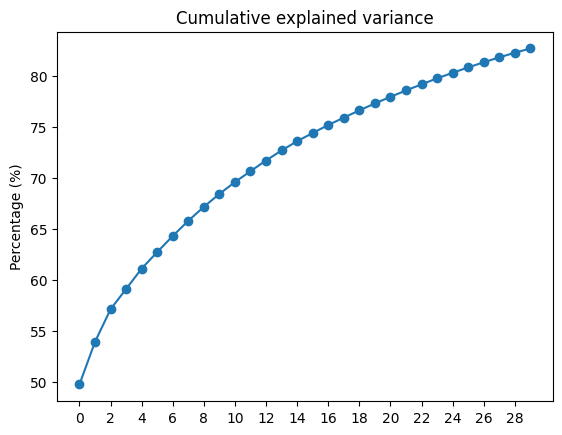

In [31]:
plt.plot(np.cumsum(tsvd_randomized.explained_var_ratio) * 100, "o-")
plt.title("Cumulative explained variance")
plt.ylabel("Percentage (%)")
plt.xticks(range(0, n_components, 2))
plt.show()

In [29]:
print(
    f"Variance explained by {n_components} components:",
    f"{np.sum(tsvd_randomized.explained_var_ratio) * 100:.2f}%"
)

Variance explained by 30 components: 82.70%


It is good practice to close the Xarray object, to release any resources linked to it, and to close the Dask cluster.

In [32]:
X.close()

In [33]:
client.close()

## Conclusion

In conclusion, we can achieve a high accuracy with the randomized SVD algorithm, as long as we specify an appropriate number of oversamples and power iterations. The randomized algorithm is also much faster and scalable. Another advantage is that it can deal with array chunking in both directions, i.e. the array does not necessarily need to be tall-and-skinny or short-and-fat. Additionally, we have also seen that with only 30 SVD components we can explain over 80% of the total variance, highlighting that the ERA5 dataset is clearly low-rank and that SVD can achieve high compression ratios whilst retaining most of the information.